In [18]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.windows import Window

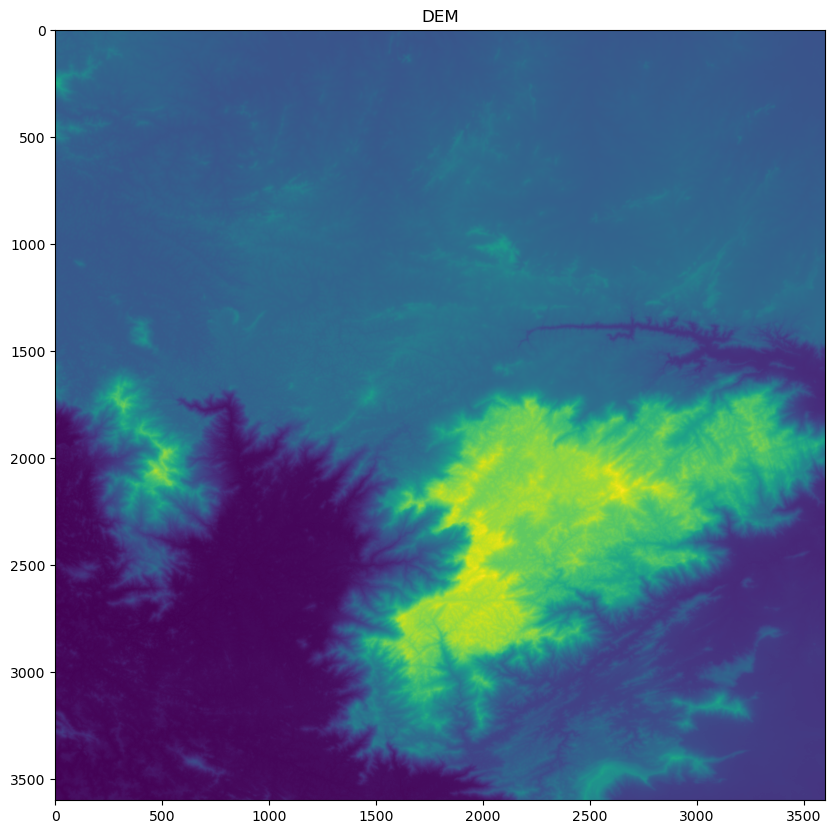

In [19]:
with rasterio.open('cdnc43e.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1))
    ax.set_title('DEM')
    plt.show()

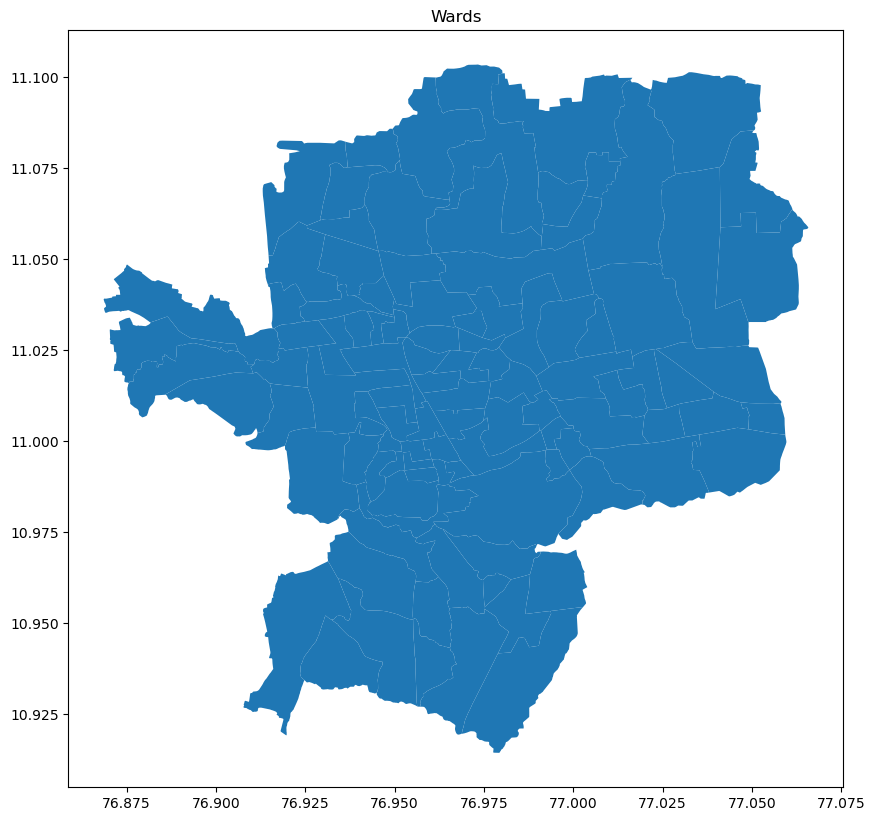

In [20]:
wards = gpd.read_file('Cbe2011Wards.shp')
fig, ax = plt.subplots(figsize=(10, 10))
wards.plot(ax=ax)
ax.set_title('Wards')
plt.show()

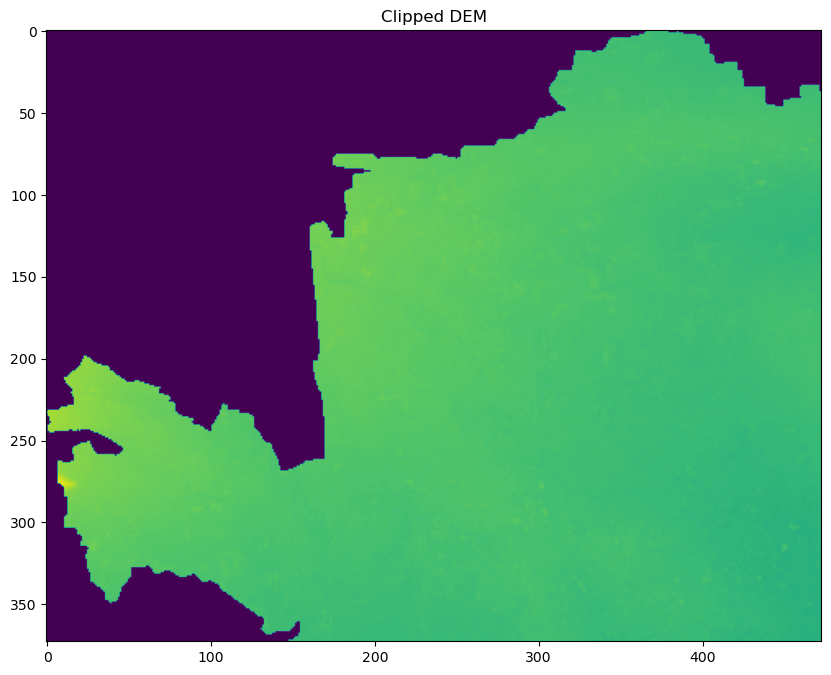

In [21]:
with rasterio.open('cdnc43e.tif') as src:
    out_image, out_transform = mask(src, wards.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    with rasterio.open("clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

with rasterio.open('clipped.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1))
    ax.set_title('Clipped DEM')
    plt.show()

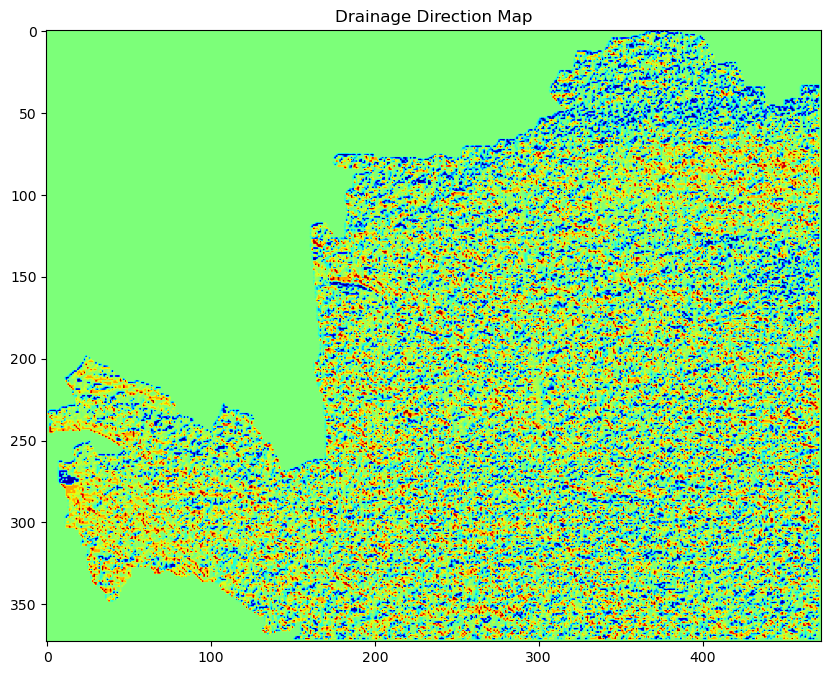

In [22]:
with rasterio.open('clipped.tif') as src:
    dem = src.read(1)
    rows, cols = dem.shape
    d8 = np.zeros((rows, cols), dtype=np.int8)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            d8[i, j] = 0
            if dem[i, j] > dem[i - 1, j]:
                d8[i, j] += 1
            if dem[i, j] > dem[i - 1, j + 1]:
                d8[i, j] += 2
            if dem[i, j] > dem[i, j + 1]:
                d8[i, j] += 4
            if dem[i, j] > dem[i + 1, j + 1]:
                d8[i, j] += 8
            if dem[i, j] > dem[i + 1, j]:
                d8[i, j] += 16
            if dem[i, j] > dem[i + 1, j - 1]:
                d8[i, j] += 32
            if dem[i, j] > dem[i, j - 1]:
                d8[i, j] += 64
            if dem[i, j] > dem[i - 1, j - 1]:
                d8[i, j] += 128

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(d8, cmap='jet')
ax.set_title('Drainage Direction Map')
plt.show()

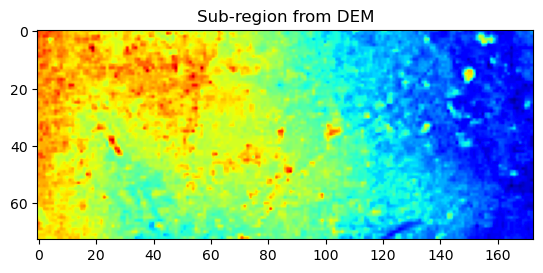

In [23]:
with rasterio.open('clipped.tif') as src:
    transform = src.transform
    full_dem = src.read(1)
    
    x_center, y_center = 400, 400  
    
    radius = 100
    
    col_off = x_center - radius
    row_off = y_center - radius
    width = height = 2 * radius
    
    window = Window(col_off=col_off, row_off=row_off, width=width, height=height)
    sub_dem = src.read(1, window=window)
    
    plt.imshow(sub_dem, cmap='jet')
    plt.title('Sub-region from DEM')
    plt.show()

with rasterio.open('sub_dem.tif', 'w', **src.meta) as dst:
    dst.write(sub_dem, 1)

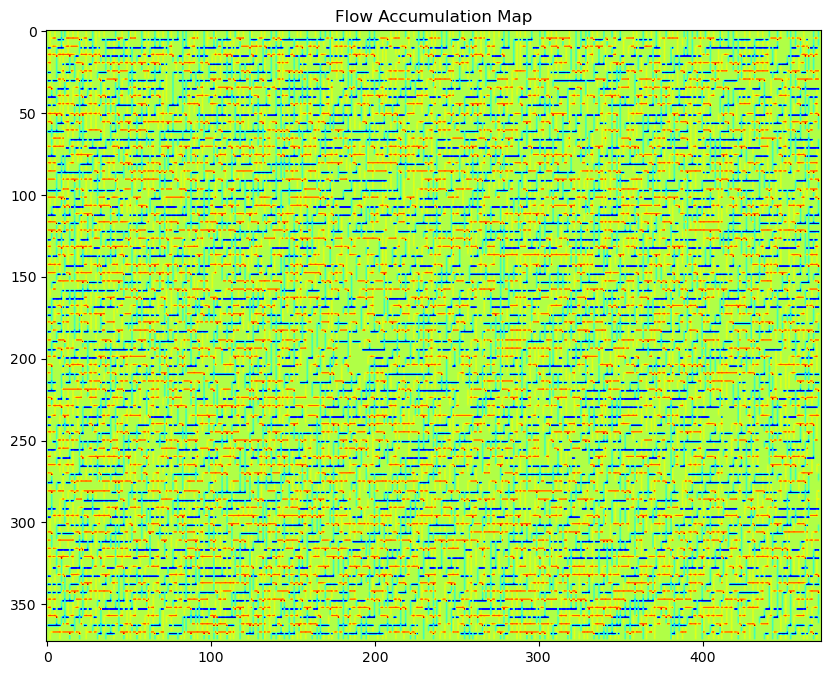

In [24]:
with rasterio.open('sub_dem.tif') as src:
    dem = src.read(1)
    rows, cols = dem.shape
    d8 = np.zeros((rows, cols), dtype=np.int8)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            d8[i, j] = 0
            if dem[i, j] > dem[i - 1, j]:
                d8[i, j] += 1
            if dem[i, j] > dem[i - 1, j + 1]:
                d8[i, j] += 2
            if dem[i, j] > dem[i, j + 1]:
                d8[i, j] += 4
            if dem[i, j] > dem[i + 1, j + 1]:
                d8[i, j] += 8
            if dem[i, j] > dem[i + 1, j]:
                d8[i, j] += 16
            if dem[i, j] > dem[i + 1, j - 1]:
                d8[i, j] += 32
            if dem[i, j] > dem[i, j - 1]:
                d8[i, j] += 64
            if dem[i, j] > dem[i - 1, j - 1]:
                d8[i, j] += 128

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(d8, cmap='jet')
ax.set_title('Flow Accumulation Map')
plt.show()

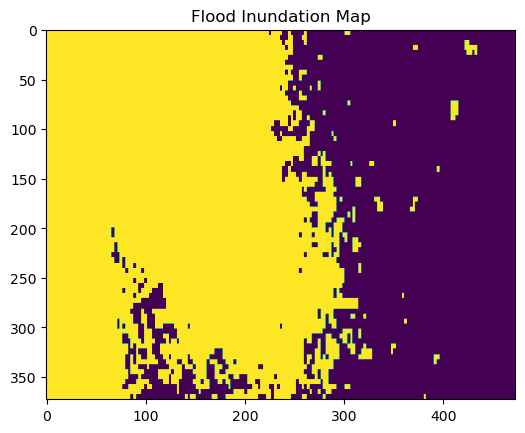

In [25]:
with rasterio.open('sub_dem.tif') as src:
    transform = src.transform
    full_dem = src.read(1)

    flood_level = 328
    flood_depth = 50

    flood_map = np.where(full_dem > flood_level, flood_depth, 0)

    plt.imshow(flood_map)
    plt.title('Flood Inundation Map')
    plt.show()

In [26]:
with rasterio.open('sub_dem.tif') as src:
    transform = src.transform
    full_dem = src.read(1)
    print(full_dem)

[[348 348 348 ... 317 320 320]
 [348 348 348 ... 317 320 320]
 [348 348 348 ... 317 320 320]
 ...
 [340 340 340 ... 311 310 310]
 [340 340 340 ... 311 310 310]
 [340 340 340 ... 311 310 310]]


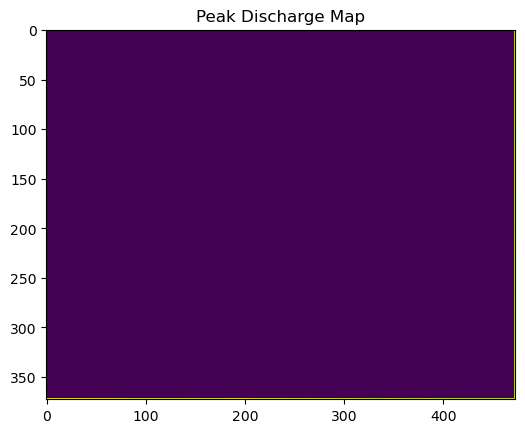

In [29]:
with rasterio.open('sub_dem.tif') as src:
    dem = src.read(1)
    runoff = 0.2 * (1 - np.exp(-0.2 * dem))
    cell_area = src.res[0] * src.res[1]
    rainfall_intensity = 0.9 
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            dem[i, j] = runoff[i, j] * rainfall_intensity * cell_area

    plt.imshow(dem)
    plt.title('Peak Discharge Map')
    plt.show()

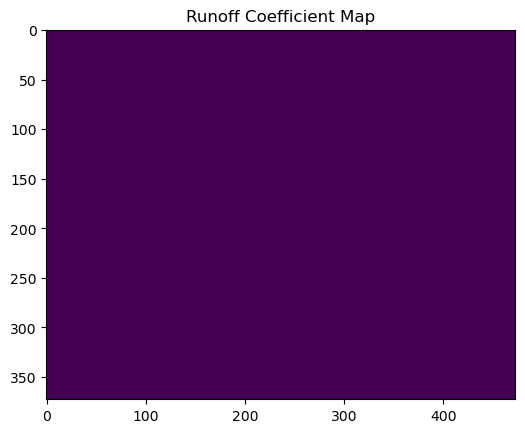

In [30]:
with rasterio.open('sub_dem.tif') as src:
    slope = src.read(1)
    runoff = 0.5 * (1 - np.exp(-0.5 * slope))
    plt.imshow(runoff)
    plt.title('Runoff Coefficient Map')
    plt.show()

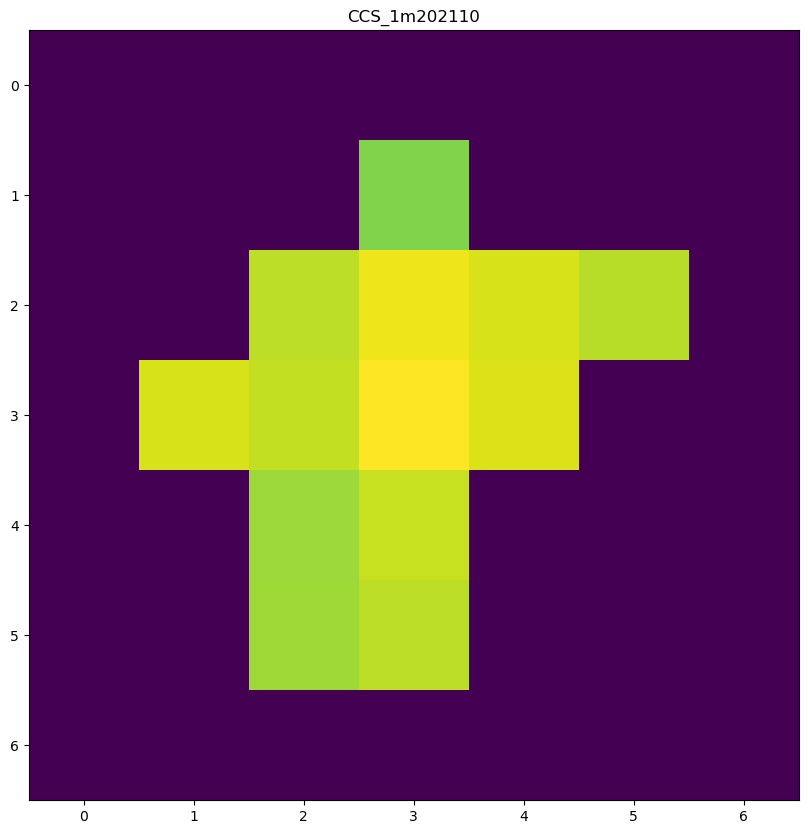

In [31]:
with rasterio.open('CCS_1m202110.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1))
    ax.set_title('CCS_1m202110')
    plt.show()